In [1]:
#https://arxiv.org/pdf/1406.2661.pdf
#implementation of The GAN network 
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.autograd import  Variable
import torch.nn.functional as F
from torchvision.utils import save_image

In [33]:
def to_var(x): #conver  x to Variable 
    return Variable(x)

def denorm(x):
    out = (x+1)/2
    return out.clamp(0,1)

In [34]:
#Image Processing

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5),
                        std = (0.5,0.5,0.5))
])
#MNIST dataset
mnist = datasets.MNIST(root='./data/',
                       train=True,
                       transform=transform,
                       download=False)
# Data loader
data_loader = torch.utils.data.DataLoader(dataset=mnist,
                                          batch_size=100, 
                                          shuffle=True)

In [38]:
#Discriminator
D = nn.Sequential(
    nn.Linear(784,256),
    nn.LeakyReLU(0.2),
    nn.Linear(256,256),
    nn.LeakyReLU(0.2),
    nn.Linear(256,1),
    nn.Sigmoid())

#Generator
G = nn.Sequential(
    nn.Linear(64,256),
    nn.LeakyReLU(0.2),
    nn.Linear(256,256),
    nn.LeakyReLU(0.2),
    nn.Linear(256,784),
    nn.Tanh())

criterion = nn.BCELoss() #Binary Cross Entropy Loss

d_optimizer = torch.optim.Adam(D.parameters(),lr=0.0003)  # Adam Optimizer for Discriminator

g_optimizer = torch.optim.Adam(G.parameters(),lr = 0.0003) # Adam Optimizer for Generator

In [92]:
D_loss = []
G_loss = []
for epoch in (range(200)):
    for i,(images,_) in enumerate(data_loader):
        batch_size = images.size(0)  #batch size here 100
        images = to_var(images.view(batch_size,-1))  # converting to Variable with dimension 100*784
        """Discrimintaor results either True or False so for the real data it will result in 1 and 
        for fake data result in 0"""
        real_labels = to_var(torch.ones(batch_size,1))  # label for real data
        fake_labels = to_var(torch.zeros(batch_size,1))  # label for fake data
        
        # calcualting loss for real_images 
        out = D(images)
        real_loss = criterion(out,real_labels)
        real_outputs = out
        
        # calculate loss for fake images
        z_  = to_var(torch.randn(100,64)) #random noise
        fake_images = G(z_) #image generated from generator using random noise
        out = D(fake_images) 
        fake_loss = criterion(out,fake_labels) #Loss on fake images
        fake_outputs = out
        # Total loss + backprop + optimizer
        """
            Original paper has loss function = log(x) + log(1-D(G(z)))  and we maximize it for Training D
            but here,
            we are trying to minimize the d_loss bcoz there is a negative sign in our loss function
            real_loss = -log(x) where x is output of D when input to D belongs to real_Data
            fake_loss = -log(1-D(G(z))) 
            d_loss = - log(x) - log(1-D(G(z))) 
            each value inside the log is b/w 0 to 1
        """
        d_loss  = real_loss + fake_loss
        D.zero_grad()
        d_loss.backward()
        d_optimizer.step() #only optimize the parameters of Discriminator
        
        #Training Generator
        z_ = to_var(torch.randn(100,64)) # Random Noise to train Generator
        fake_images = G(z_)
        out = D(fake_images)
        # Here loss is -log(D(G(z))) and we are trying to minimize it
        g_loss= criterion(out,real_labels)
        # backprop the loss
        G.zero_grad()
        D.zero_grad() 
        g_loss.backward() 
        g_optimizer.step() # only optimize the Paramters of  The Generator Part
        
        if (i+1) % 300 == 0:
            print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, '
            'g_loss: %.4f, D(x): %.2f, D(G(z)): %.2f' 
            %(epoch, 200, i+1, 600, d_loss.data[0], g_loss.data[0],
              real_outputs.data.mean(), fake_outputs.data.mean()))
            D_loss.append(d_loss.data[0])
            G_loss.append(g_loss.data[0])
        if (epoch+1) == 1:
            images = images.view(images.size(0), 1, 28, 28)
            save_image(denorm(images.data), './data/real_images.png')
    
    # Save sampled images
    fake_images = fake_images.view(fake_images.size(0), 1, 28, 28)
    save_image(denorm(fake_images.data), './data/fake_images-%d.png' %(epoch+1))

Epoch [0/200], Step[300/600], d_loss: 0.0158, g_loss: 13.7241, D(x): 0.99, D(G(z)): 0.00
Epoch [0/200], Step[600/600], d_loss: 0.0928, g_loss: 15.5552, D(x): 0.95, D(G(z)): 0.00
Epoch [1/200], Step[300/600], d_loss: 0.0696, g_loss: 10.7480, D(x): 1.00, D(G(z)): 0.03
Epoch [1/200], Step[600/600], d_loss: 0.0478, g_loss: 17.6875, D(x): 0.98, D(G(z)): 0.01
Epoch [2/200], Step[300/600], d_loss: 0.0283, g_loss: 16.6102, D(x): 0.99, D(G(z)): 0.00
Epoch [2/200], Step[600/600], d_loss: 0.0997, g_loss: 13.6791, D(x): 0.98, D(G(z)): 0.04
Epoch [3/200], Step[300/600], d_loss: 0.0187, g_loss: 16.3657, D(x): 0.98, D(G(z)): 0.00
Epoch [3/200], Step[600/600], d_loss: 0.0144, g_loss: 14.9844, D(x): 0.99, D(G(z)): 0.01
Epoch [4/200], Step[300/600], d_loss: 0.0082, g_loss: 15.4579, D(x): 0.99, D(G(z)): 0.00
Epoch [4/200], Step[600/600], d_loss: 0.0537, g_loss: 14.1998, D(x): 1.00, D(G(z)): 0.02
Epoch [5/200], Step[300/600], d_loss: 0.0733, g_loss: 11.1246, D(x): 0.99, D(G(z)): 0.03
Epoch [5/200], Step[6

Epoch [46/200], Step[300/600], d_loss: 0.0087, g_loss: 16.0525, D(x): 0.99, D(G(z)): 0.00
Epoch [46/200], Step[600/600], d_loss: 0.1514, g_loss: 17.7241, D(x): 0.94, D(G(z)): 0.00
Epoch [47/200], Step[300/600], d_loss: 0.0071, g_loss: 16.4235, D(x): 1.00, D(G(z)): 0.01
Epoch [47/200], Step[600/600], d_loss: 0.0153, g_loss: 15.5154, D(x): 0.99, D(G(z)): 0.01
Epoch [48/200], Step[300/600], d_loss: 0.0110, g_loss: 16.7704, D(x): 0.99, D(G(z)): 0.00
Epoch [48/200], Step[600/600], d_loss: 0.0404, g_loss: 14.5179, D(x): 1.00, D(G(z)): 0.02
Epoch [49/200], Step[300/600], d_loss: 0.0440, g_loss: 16.8447, D(x): 0.99, D(G(z)): 0.01
Epoch [49/200], Step[600/600], d_loss: 0.0291, g_loss: 16.1838, D(x): 0.98, D(G(z)): 0.00
Epoch [50/200], Step[300/600], d_loss: 0.0129, g_loss: 16.7977, D(x): 0.99, D(G(z)): 0.01
Epoch [50/200], Step[600/600], d_loss: 0.0453, g_loss: 18.7586, D(x): 0.98, D(G(z)): 0.00
Epoch [51/200], Step[300/600], d_loss: 0.0455, g_loss: 17.9375, D(x): 0.98, D(G(z)): 0.01
Epoch [51/

Epoch [92/200], Step[300/600], d_loss: 0.0147, g_loss: 16.9463, D(x): 0.99, D(G(z)): 0.00
Epoch [92/200], Step[600/600], d_loss: 0.0285, g_loss: 15.8126, D(x): 0.99, D(G(z)): 0.01
Epoch [93/200], Step[300/600], d_loss: 0.0379, g_loss: 18.3416, D(x): 0.98, D(G(z)): 0.00
Epoch [93/200], Step[600/600], d_loss: 0.0112, g_loss: 17.7214, D(x): 0.99, D(G(z)): 0.00
Epoch [94/200], Step[300/600], d_loss: 0.0171, g_loss: 18.2679, D(x): 0.99, D(G(z)): 0.00
Epoch [94/200], Step[600/600], d_loss: 0.0277, g_loss: 19.3162, D(x): 0.99, D(G(z)): 0.00
Epoch [95/200], Step[300/600], d_loss: 0.0185, g_loss: 16.9108, D(x): 0.99, D(G(z)): 0.00
Epoch [95/200], Step[600/600], d_loss: 0.0213, g_loss: 17.6686, D(x): 0.98, D(G(z)): 0.00
Epoch [96/200], Step[300/600], d_loss: 0.0165, g_loss: 16.5067, D(x): 0.99, D(G(z)): 0.01
Epoch [96/200], Step[600/600], d_loss: 0.0472, g_loss: 17.3225, D(x): 0.97, D(G(z)): 0.00
Epoch [97/200], Step[300/600], d_loss: 0.1200, g_loss: 15.0984, D(x): 0.99, D(G(z)): 0.03
Epoch [97/

Epoch [137/200], Step[600/600], d_loss: 0.0070, g_loss: 15.4919, D(x): 0.99, D(G(z)): 0.00
Epoch [138/200], Step[300/600], d_loss: 0.0192, g_loss: 19.4324, D(x): 0.99, D(G(z)): 0.00
Epoch [138/200], Step[600/600], d_loss: 0.0016, g_loss: 19.0812, D(x): 1.00, D(G(z)): 0.00
Epoch [139/200], Step[300/600], d_loss: 0.0075, g_loss: 16.5518, D(x): 0.99, D(G(z)): 0.00
Epoch [139/200], Step[600/600], d_loss: 0.0146, g_loss: 17.9905, D(x): 1.00, D(G(z)): 0.01
Epoch [140/200], Step[300/600], d_loss: 0.0047, g_loss: 15.8992, D(x): 1.00, D(G(z)): 0.00
Epoch [140/200], Step[600/600], d_loss: 0.0015, g_loss: 19.3758, D(x): 1.00, D(G(z)): 0.00
Epoch [141/200], Step[300/600], d_loss: 0.0255, g_loss: 18.5555, D(x): 0.98, D(G(z)): 0.00
Epoch [141/200], Step[600/600], d_loss: 0.0078, g_loss: 18.2954, D(x): 0.99, D(G(z)): 0.00
Epoch [142/200], Step[300/600], d_loss: 0.0085, g_loss: 17.6785, D(x): 0.99, D(G(z)): 0.00
Epoch [142/200], Step[600/600], d_loss: 0.0038, g_loss: 19.0076, D(x): 1.00, D(G(z)): 0.00

Epoch [183/200], Step[300/600], d_loss: 0.0066, g_loss: 17.3292, D(x): 1.00, D(G(z)): 0.00
Epoch [183/200], Step[600/600], d_loss: 0.0225, g_loss: 19.5429, D(x): 0.99, D(G(z)): 0.01
Epoch [184/200], Step[300/600], d_loss: 0.0468, g_loss: 17.9586, D(x): 0.99, D(G(z)): 0.01
Epoch [184/200], Step[600/600], d_loss: 0.0221, g_loss: 19.9402, D(x): 0.98, D(G(z)): 0.00
Epoch [185/200], Step[300/600], d_loss: 0.0324, g_loss: 18.1258, D(x): 1.00, D(G(z)): 0.02
Epoch [185/200], Step[600/600], d_loss: 0.0503, g_loss: 17.8125, D(x): 0.99, D(G(z)): 0.01
Epoch [186/200], Step[300/600], d_loss: 0.0121, g_loss: 18.6594, D(x): 1.00, D(G(z)): 0.01
Epoch [186/200], Step[600/600], d_loss: 0.0078, g_loss: 14.6807, D(x): 1.00, D(G(z)): 0.01
Epoch [187/200], Step[300/600], d_loss: 0.0387, g_loss: 17.1250, D(x): 0.98, D(G(z)): 0.00
Epoch [187/200], Step[600/600], d_loss: 0.0181, g_loss: 19.9773, D(x): 0.99, D(G(z)): 0.00
Epoch [188/200], Step[300/600], d_loss: 0.0743, g_loss: 17.1092, D(x): 1.00, D(G(z)): 0.04

In [127]:
z_ = to_var(torch.randn(100,64)) # Random Noise to train Generator
fake_images = G(z_)
out = D(fake_images)
g_loss= criterion(out,to_var(torch.zeros(100,1)))
g_loss


Variable containing:
1.00000e-04 *
  4.4741
[torch.FloatTensor of size 1]

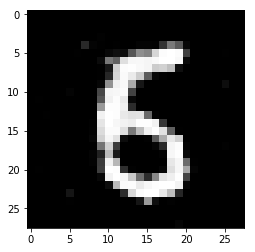

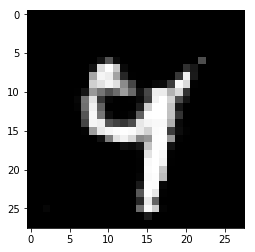

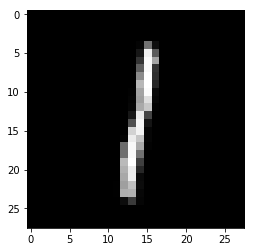

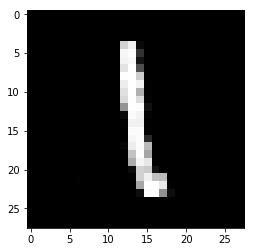

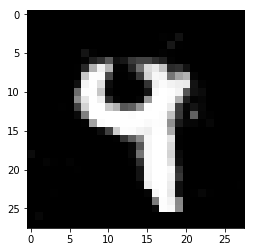

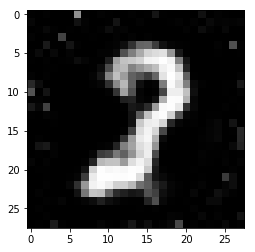

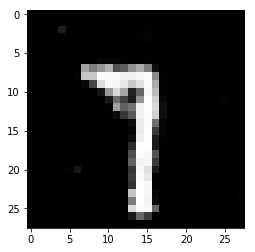

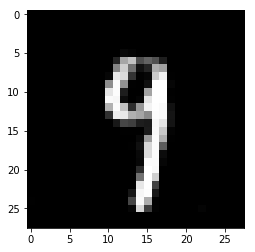

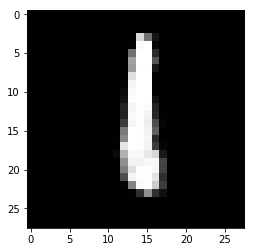

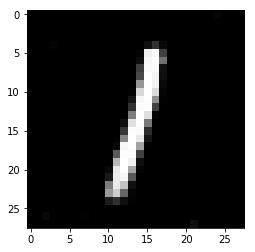

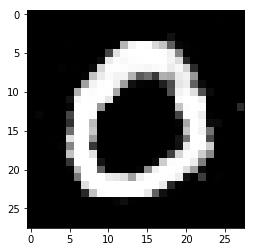

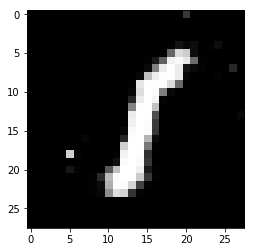

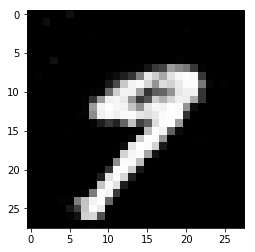

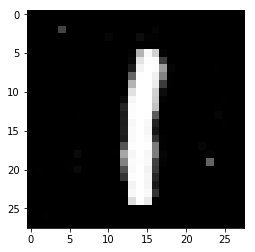

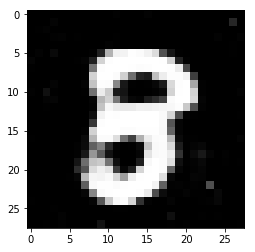

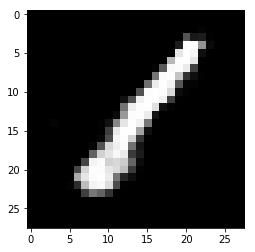

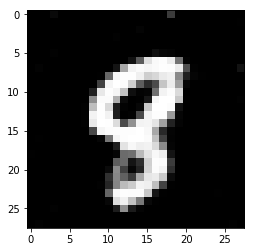

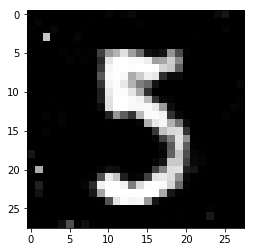

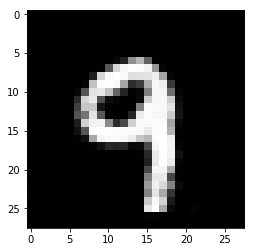

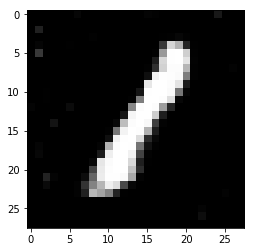

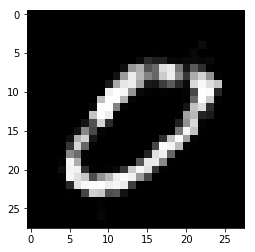

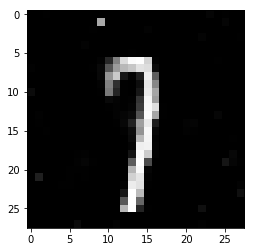

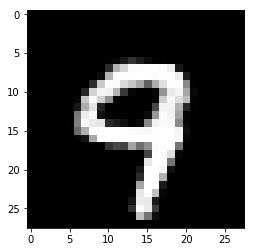

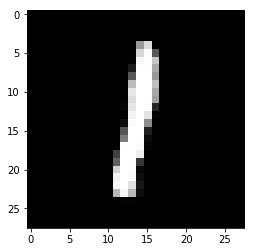

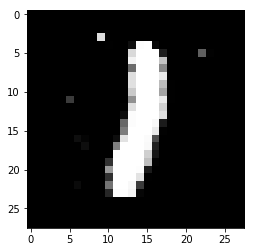

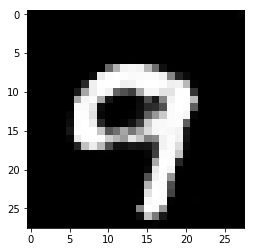

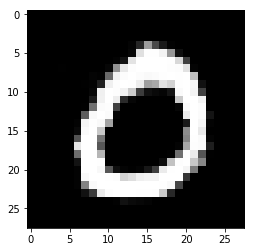

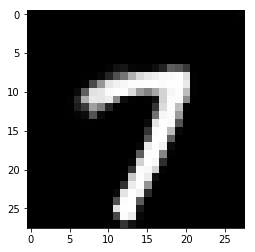

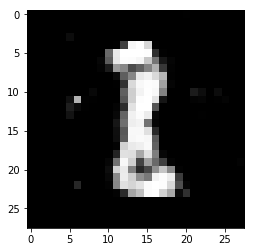

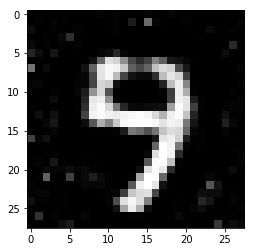

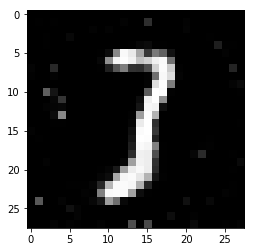

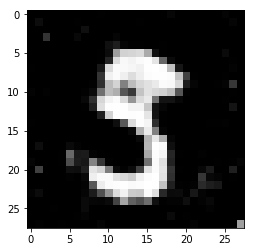

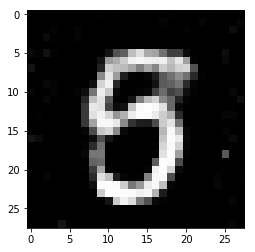

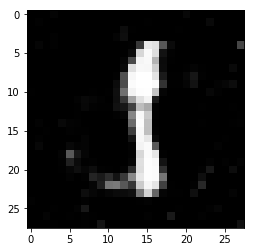

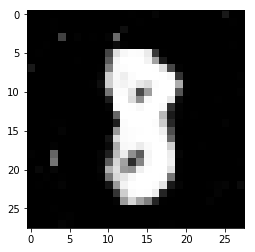

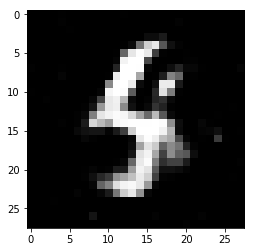

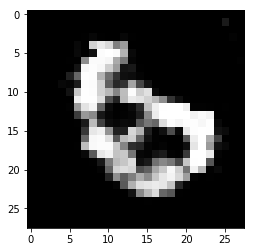

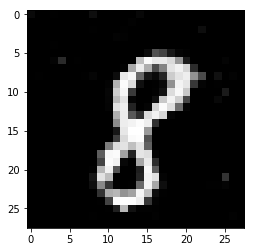

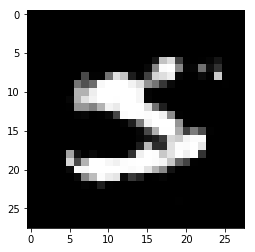

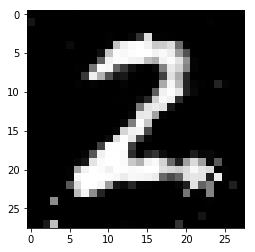

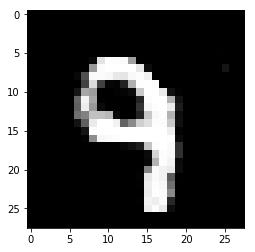

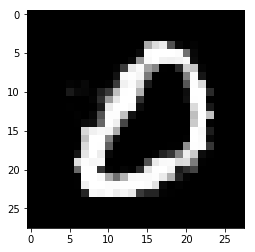

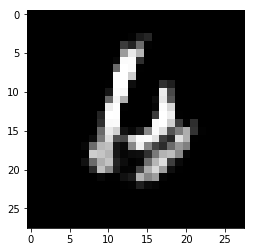

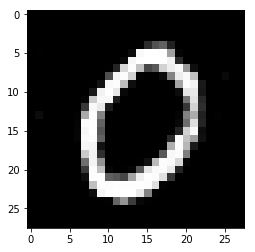

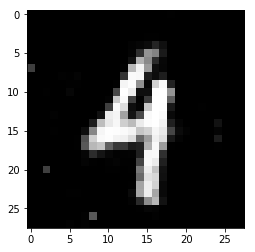

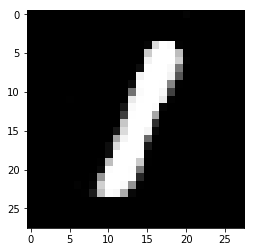

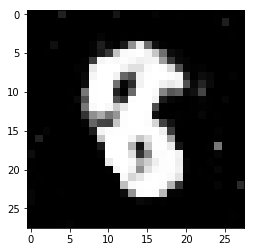

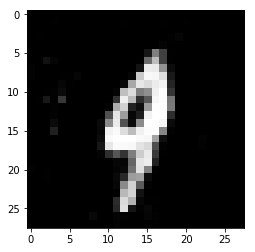

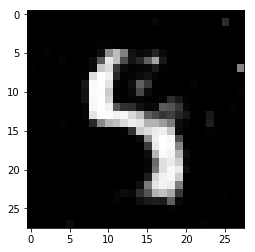

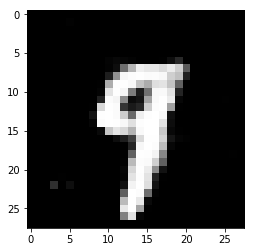

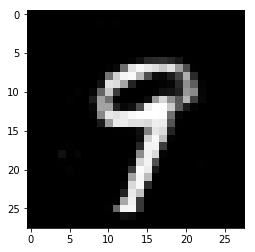

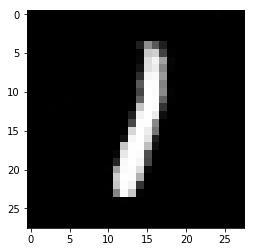

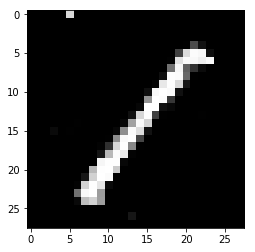

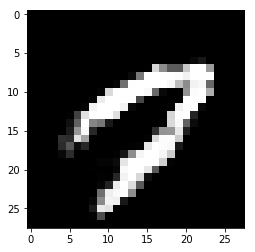

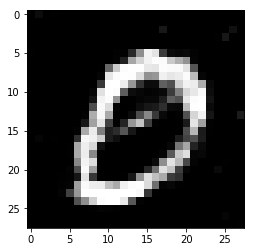

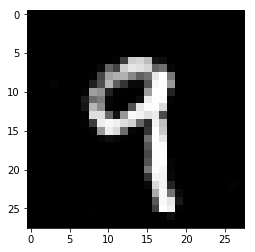

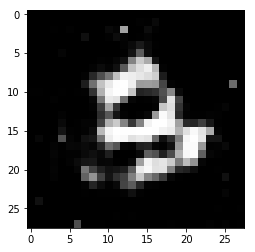

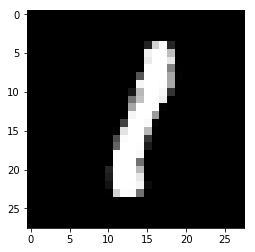

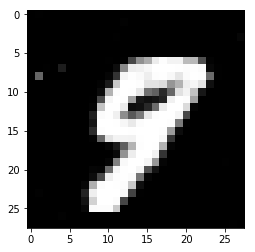

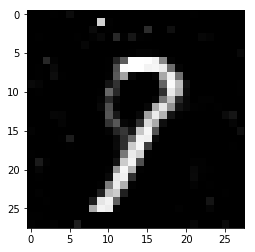

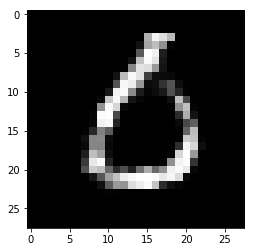

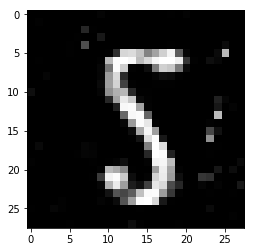

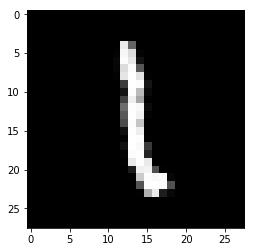

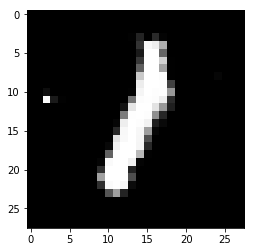

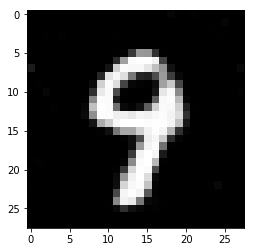

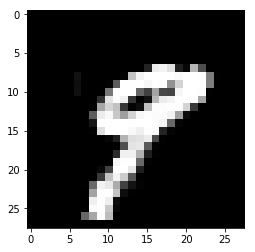

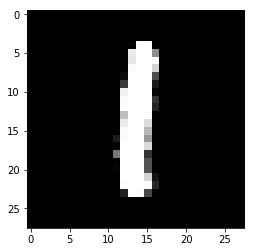

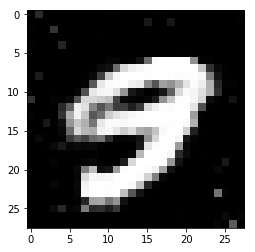

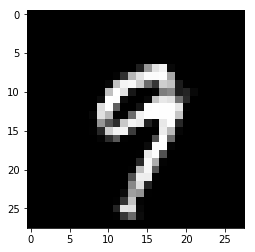

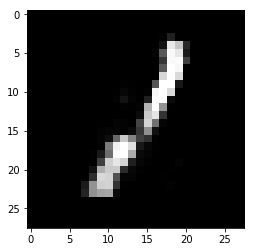

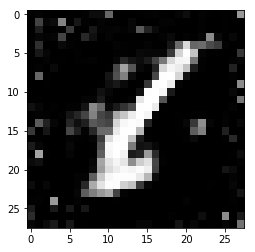

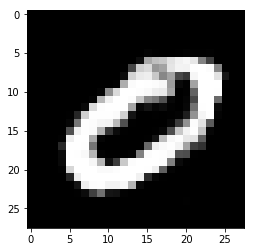

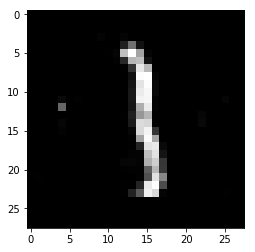

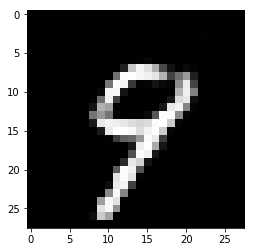

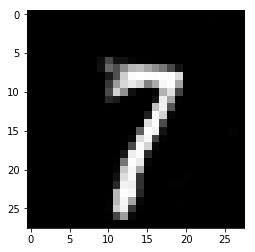

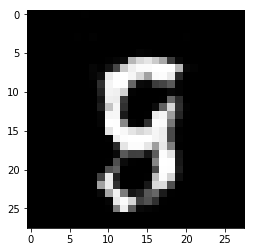

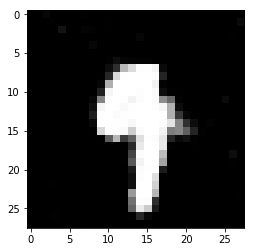

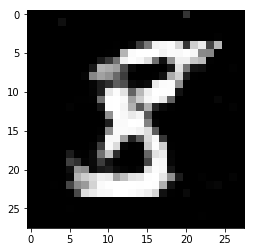

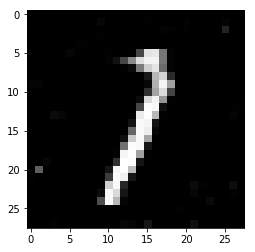

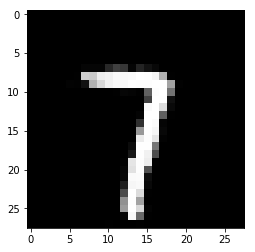

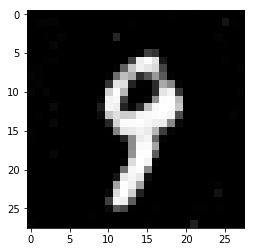

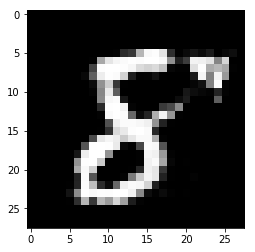

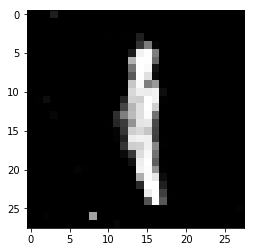

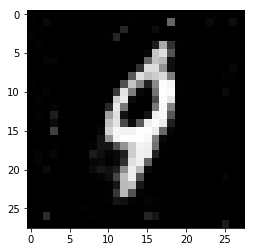

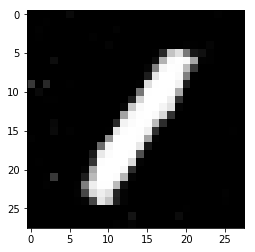

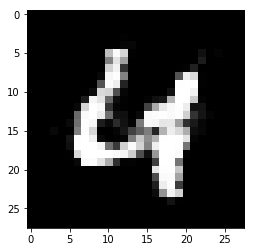

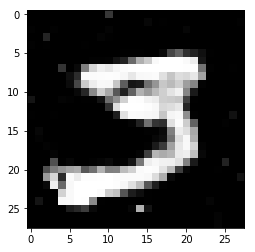

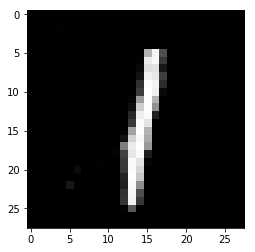

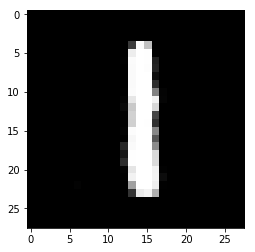

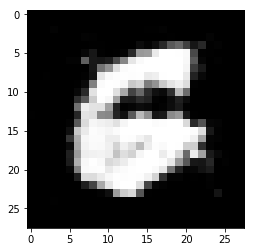

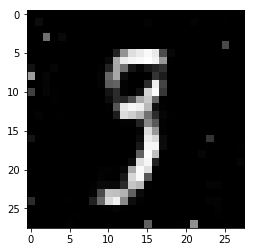

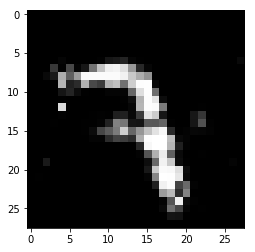

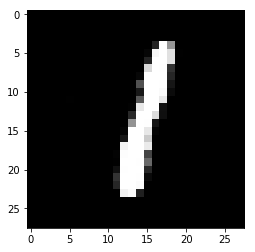

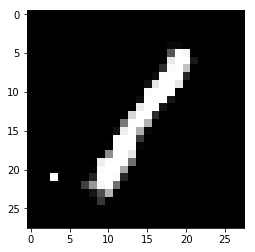

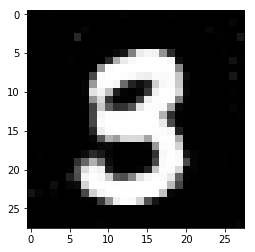

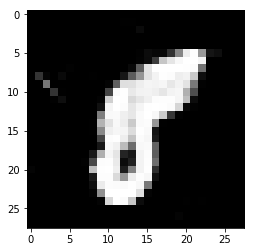

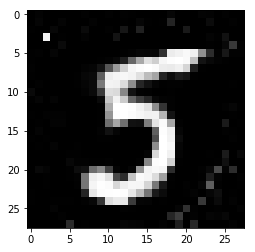

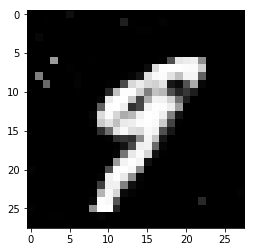

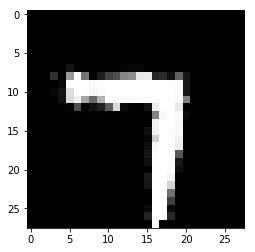

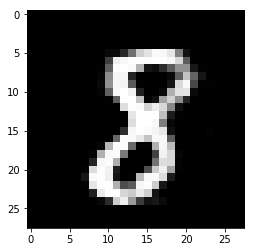

In [128]:
import matplotlib.pyplot as plt
for i in range(100):
    fake = denorm(fake_images.data[i]).numpy()
    import numpy as np
    fake = np.resize(fake,(28,28))
    plt.imshow(fake,cmap="gray")
    plt.show()

In [111]:
z = Variable(torch.randn(100,64))
I = G(z)
# print(I)
I = I.view(100,1,28,28)
# save_image(I.data,'./data/abc.png')
# save_image(denorm(I.data),'./data/bcd.png')

torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])


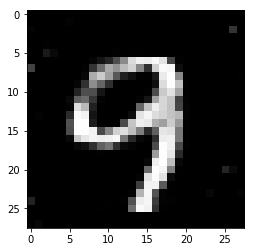

In [112]:
print(I.data.size())
a = denorm(I.data)
print(a.size())
# print((I.data[0]+1)/2)
import matplotlib.pyplot as plt
temp = transforms.ToPILImage()
temp = temp(a[0])

# print(a)
plt.imshow(temp,cmap='gray')
plt.show()

In [113]:
torch.save(G,'GANgenerator.pkl')
torch.save(D,'GANDiscriminator.pkl')